# QQQ Investment Strategy using LSTM

Our goal in this notebook is to create a simple investment strategy using a Long Short Term Memory (LSTM) neural network. We will use the [QQQ ETF](https://www.invesco.com/us/financial-products/etfs/product-detail?audienceType=Investor&ticker=QQQ) as our investment vehicle. The QQQ ETF is an exchange-traded fund based on the Nasdaq-100 Index. The Index includes 100 of the largest domestic and international nonfinancial companies listed on the Nasdaq Stock Market based on market capitalization. The QQQ ETF is one of the most traded ETFs in the world and is a good proxy for the technology sector.

Our strategy will be to use the LSTM to predict the next day's closing price and to use the prediction to derive a gain probability. We will then use the gain probability to decide whether to buy or sell the QQQ ETF. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from prophet import Prophet
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import stats
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Using device:  cuda


### Basic functions
Open the data, plot it

In [3]:
def open_data(print_head=False, print_shape=False, keep_date=False):
    df = pd.read_csv('Data\\QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()
    if not keep_date:
        df = df.reset_index(drop=True)
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

(1195, 17)
              Open    High     Low   Close      Volume  1-month  3-month  \
Date                                                                       
2019-01-02  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42   
2019-01-03  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41   
2019-01-04  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42   
2019-01-07  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45   
2019-01-08  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46   

            6-month  1-year  2-year  3-year  5-year  7-year  10-year  20-year  \
Date                                                                            
2019-01-02     2.51    2.60    2.50    2.47    2.49    2.56     2.66     2.83   
2019-01-03     2.47    2.50    2.39    2.35    2.37    2.44     2.56     2.75   
2019-01-04     2.51    2.57    2.50    2.47    2.49    2.56     2.67     2.83   
2019-01-07     2.54    2.58    2.53    2.51    2.53

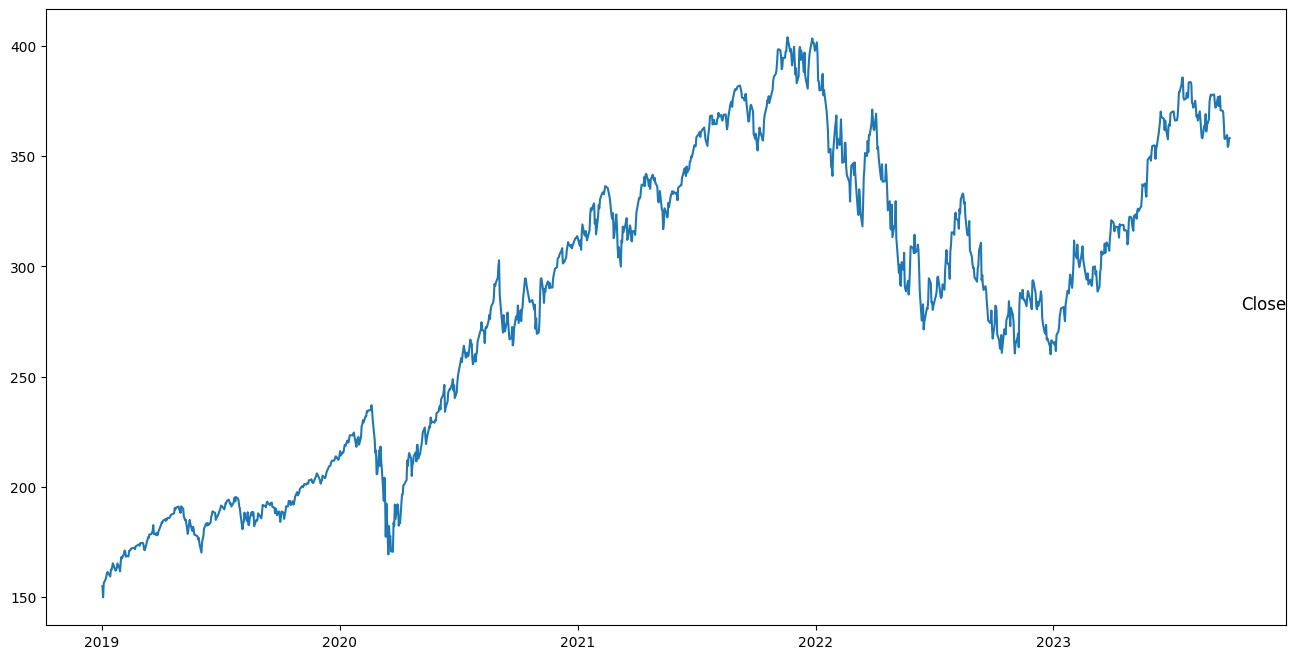

In [4]:
df = open_data(print_head=True, print_shape=True, keep_date=True)
df.index = pd.to_datetime(df.index)
plot_data(df)

To have an insight about which features to use, we plot the correlation matrix of the features.

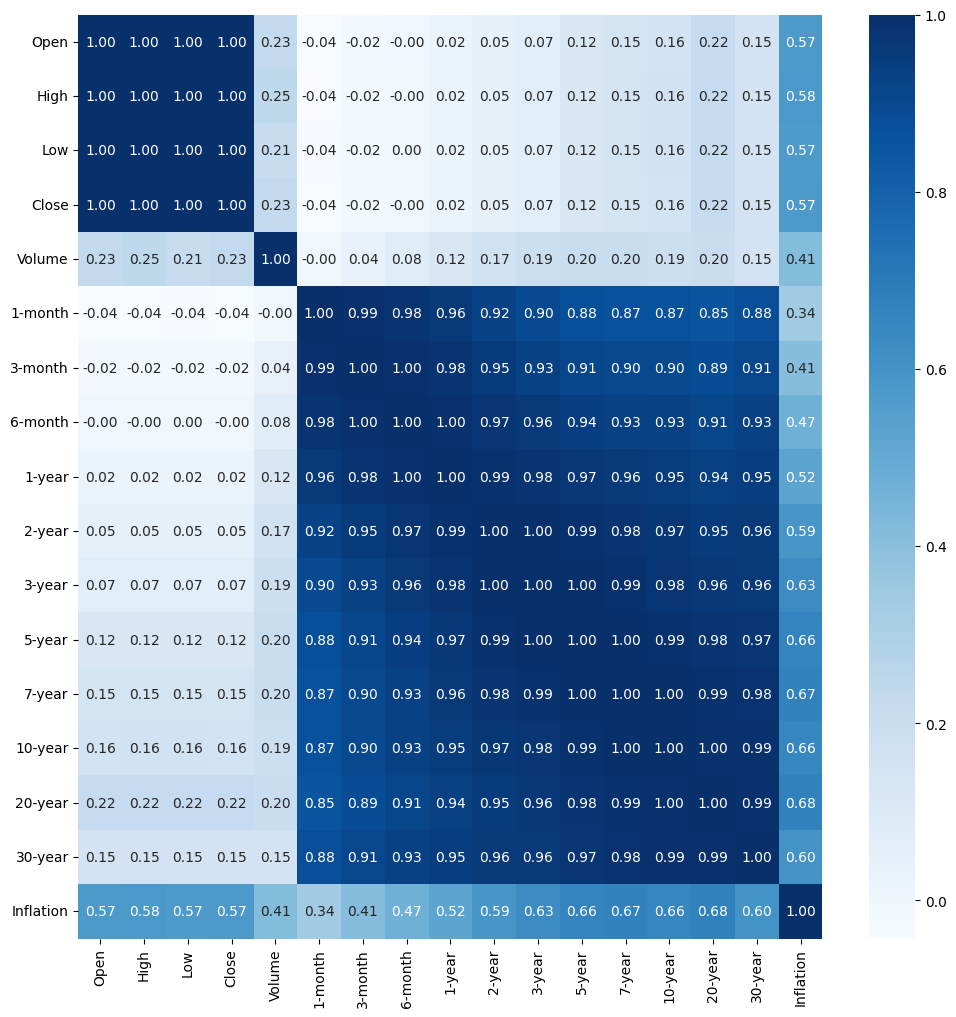

In [5]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

## Open and use the VIX data

We presume that the VIX volatility could help us to predict the QQQ ETF price. We will use the VIX data as an additional feature in our LSTM model.

                  VIX
Date                 
2018-12-18  24.680000
2018-12-19  25.150000
2018-12-20  26.090000
2018-12-21  28.240000
2018-12-24  29.290001


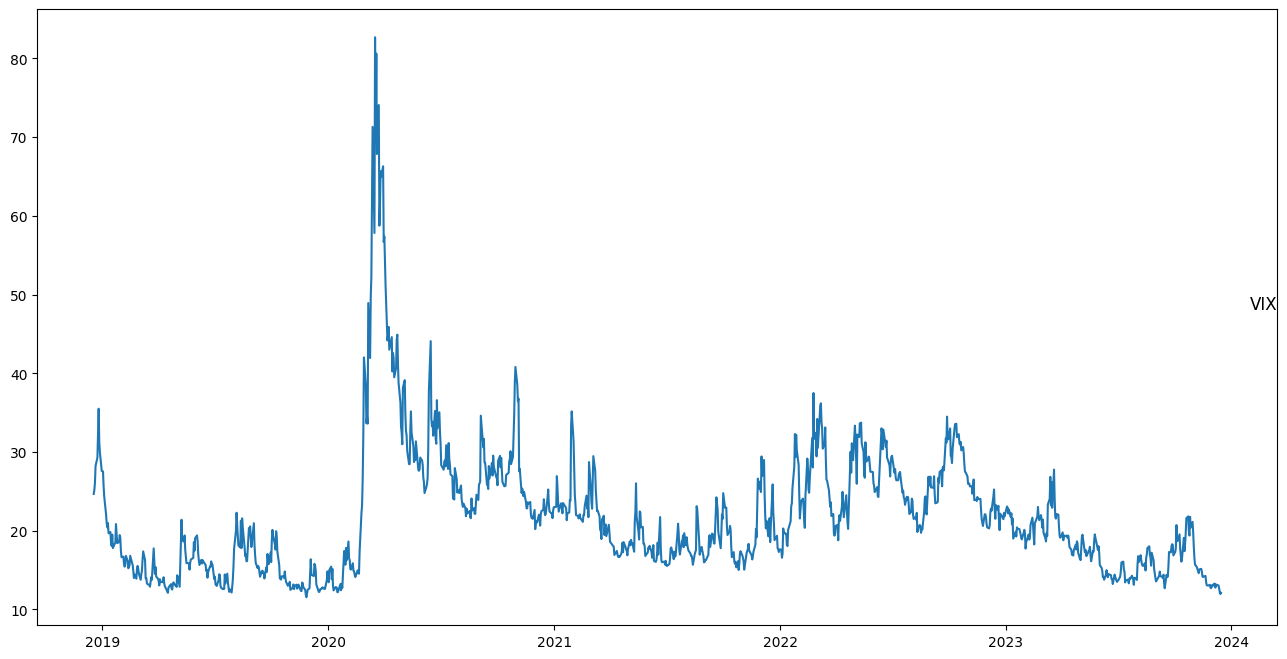

In [6]:
vix = pd.read_csv('Data\\VIX.csv', header=0, parse_dates=True)
vix.set_index('Date', inplace=True)
vix = vix.dropna()
vix = vix[['Open']]
vix.index = pd.to_datetime(vix.index)
vix.columns = ['VIX']
print(vix.head())
plot_data(vix, columns=['VIX'])

Here are the features we are going to use: we don't want to overhelm the model with too many features, and we canonly use the data we would have in real life (not the closing price, volume, high or low for example).

Therefore, we will only use the following features:
- VIX Open
- Open price
- 3 years bond yield
to predict the closing price of the QQQ ETF.

In [7]:
df = df[['Open', 'Close', '3-year']]

In [8]:
# Join VIX data accoriding to date index
data = pd.merge(df, vix, left_index=True, right_index=True)
print(data.head())

              Open   Close  3-year        VIX
Date                                         
2019-01-02  150.99  154.88    2.47  27.540001
2019-01-03  152.60  149.82    2.35  25.680000
2019-01-04  152.18  156.23    2.47  24.360001
2019-01-07  156.54  158.09    2.51  22.059999
2019-01-08  159.56  159.52    2.57  20.959999


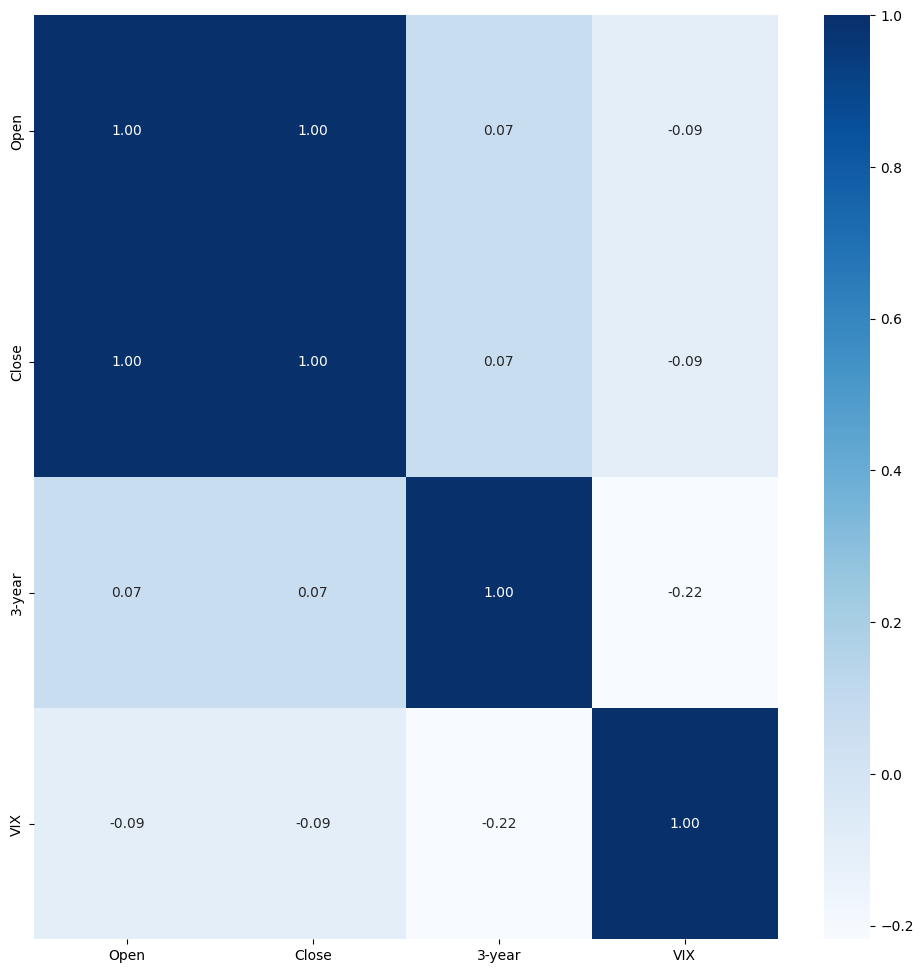

In [8]:
# Plot the correlation matrix
corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

## Data Preparation

We first scale our features using the MinMaxScaler from sklearn. We then split the data into training and testing sets. We will use the last 10% of the data for testing.
The goal of scaling the data is to have all the features in the same range. This is important for the LSTM model to work properly.


In [9]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
open_scaler = MinMaxScaler(feature_range=(0, 1))

y = data[['Close']]
X = data.drop(['Close'], axis=1)

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)
open_scaler.fit_transform(data[['Open']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

The dataset structure is the following:
- X_train: the training data, containing for each sample the 60 previous days of data for the 3 features
- y_train: the training labels, containing for each sample the next day's closing price

and will be used to train the LSTM model.

In [10]:
class StockDataset(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        return self.X[start:end+1], self.y[end]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset(X_train, y_train)
test_set = StockDataset(X_test, y_test)

## Model Building

Here are the different models we are going to try:
- LSTM with 2 LSTM layers and 3 Dense layers, quite complex
- LSTM with 1 LSTM layer and 2 Dense layers, less complex

In [11]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 2 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.linear2(self.linear(lstm_out2.view(len(seq),-1))))
        return pred[-1]
    

class LSTMnetwork_2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        #self.relu = nn.ReLU()
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        #pred = self.linear2(self.relu(self.linear(lstm_out.view(len(seq),-1))))
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]

## Model training

We train the models using the training data and the training labels. We use the Adam optimizer and the Mean Absolute Error (MAE) loss function, as our goal is to minimize big errors.

In [217]:
input_size = len(X_train[0])
model = LSTMnetwork(input_size=input_size).to(device)
criterion = nn.L1Loss()

model

best_model = None
best_loss = 1000000

In [204]:
best_loss = 1000000

100%|██████████| 40/40 [02:19<00:00,  3.48s/it]


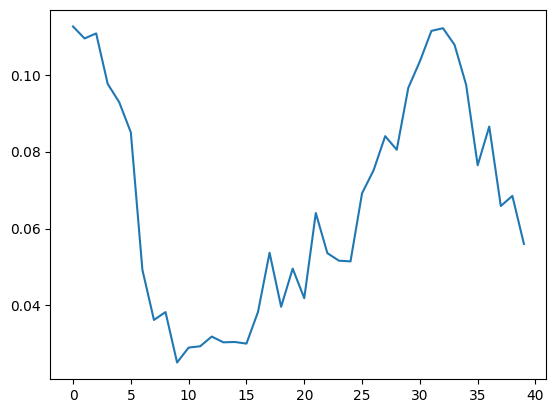

In [218]:
epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=5*10**(-5))

losses = []

for i in tqdm(range(epochs)):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    #print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    #print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

100%|██████████| 60/60 [03:38<00:00,  3.65s/it]


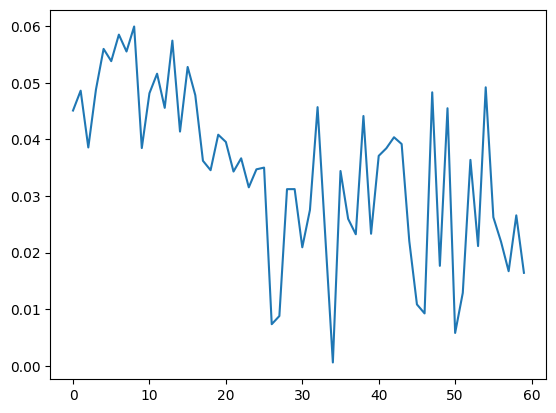

In [224]:
epochs = 60
if best_model:
    model = best_model
optimizer = torch.optim.Adam(model.parameters(), lr=5*10**(-5))

losses = []

for i in tqdm(range(epochs)):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    #print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    #print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

## Model evaluation

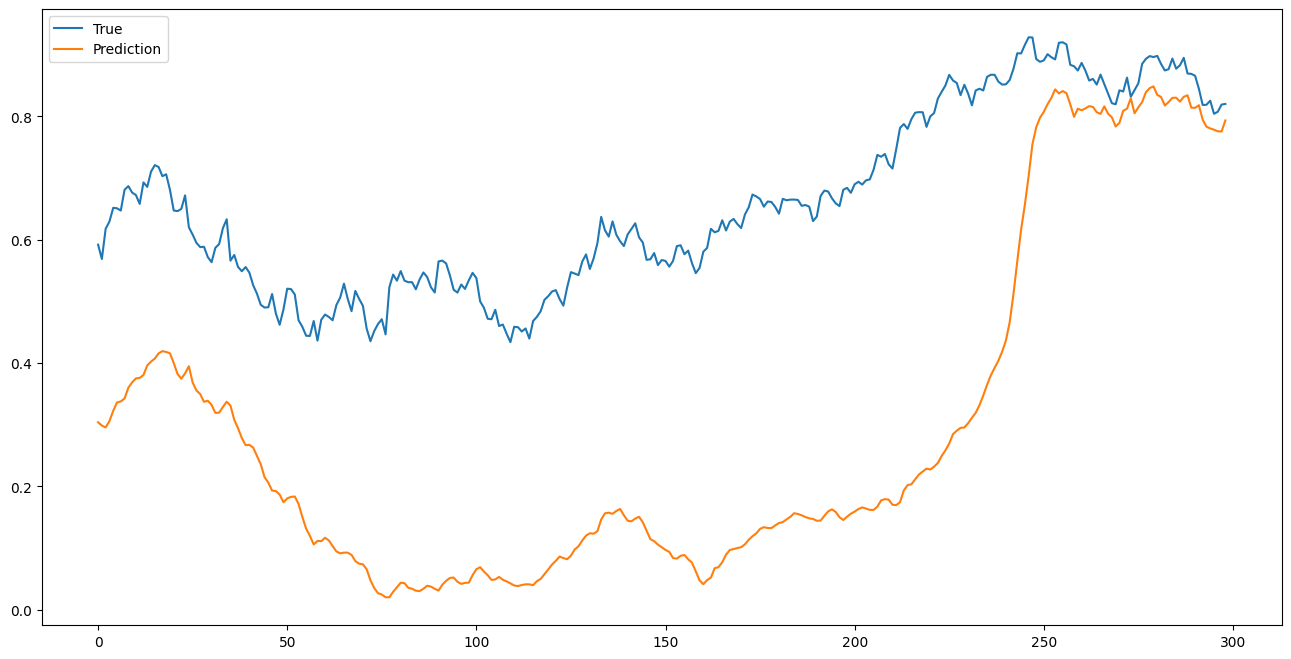

In [ ]:
# predict the test set
test_preds = []
test_values = []
for seq, y in test_set:
    best_model.hidden = (torch.zeros(1, 1, best_model.hidden_size).to(device),
                    torch.zeros(1, 1, best_model.hidden_size).to(device))
    test_values.append(y.item())
    with torch.no_grad():
        test_pred = best_model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test
window = test_set.window

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(test_values, label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

In [131]:
# Save the whole model
torch.save(best_model, 'small_model_1.pt')

## Best model

In [12]:
model = torch.load('small_model_2.pt')

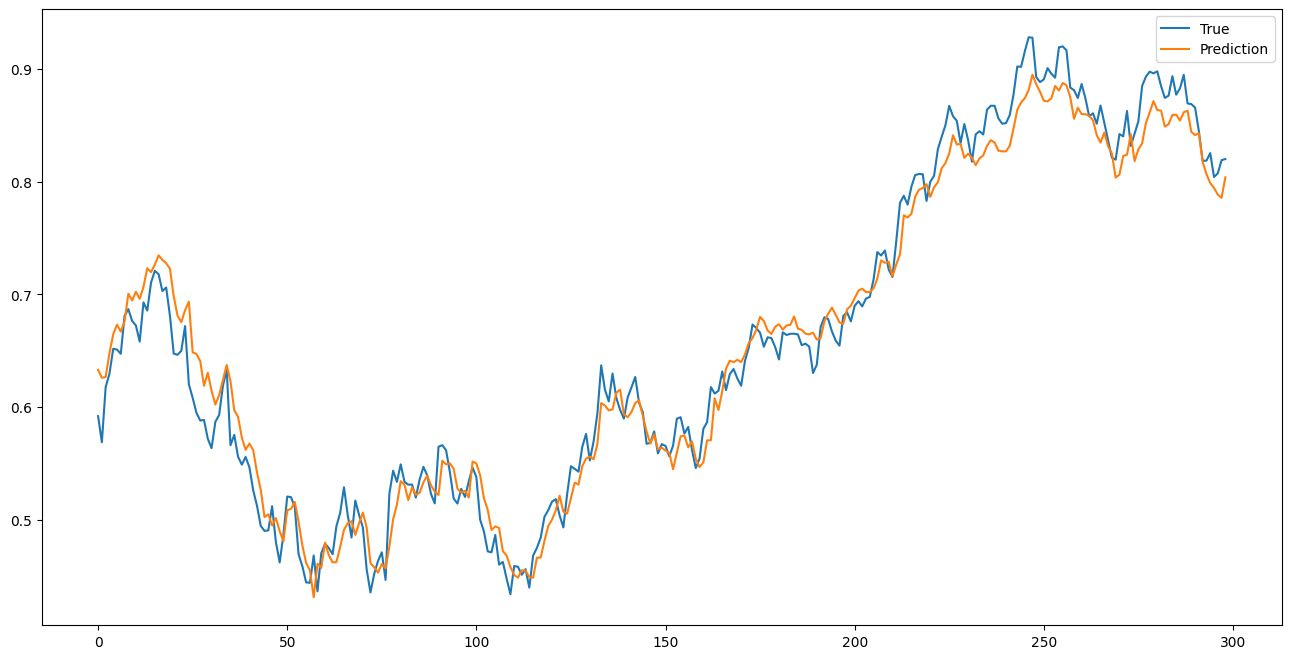

In [13]:
# predict the test set
test_preds = []
test_values = []
for seq, y in test_set:
    model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                    torch.zeros(1, 1, model.hidden_size).to(device))
    test_values.append(y.item())
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test
window = test_set.window

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(test_values, label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

When comparing the results of the different models, we can see that the best model is the one with 1 LSTM layer and 2 Dense layers. It has the lowest MAE and the lowest loss.
As our task is quite simple, we don't need a complex model to get good results.

Therefore, this is the model we are going to use for our investment strategy.

## Probability calculation

To compute the probability of the closing price being higher than the opening one, we use the following method:
- First compute the difference between the closing price and the opening price for the training set
- Then extract the standard deviation of the difference

- We assume a normal distribution of the difference between the closing price and the opening price, with mean equal to 0 and standard deviation computed above
- Then we use the forecasting price computed above to compute the probability of the closing price being higher than the opening one using the normal distribution described above: say $x_{t}$ is the forecasted price, $x_{t-1}$ is the opening price, $\sigma$ is the standard deviation of the difference between the closing price and the opening price, then the probability is $P(x_{t} > x_{t-1}) = \Phi(x_{t}-x_{t-1})$ where $\Phi$ is the cumulative distribution function of the normal distribution with mean 0 and standard deviation $\sigma$.
- Therefore, when we predict the closing price to be equal to the opening price, the probability is equal to 0.5, while when the forecasting ptice is much higher than the opening price, the probability is close to 1.

In [20]:
# Create a df with the forecast, the true value and the openining price
forecast = pd.DataFrame(test_preds, columns=['Forecast'])
forecast['True'] = test_values
forecast['Open'] = data['Open'][-len(test_values):].values
# scale opening price
forecast['Open'] = open_scaler.transform(forecast['Open'].values.reshape(-1, 1))
forecast['Date'] = data.index[-len(test_values):]
forecast.set_index('Date', inplace=True)
forecast.index = pd.to_datetime(forecast.index)
forecast.head()

d:\Jean-Baptiste\Documents\Columbia\Courses\IEOR4571\Code\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Forecast,True,Open
Date,,,
2022-07-25,0.633032,0.591927,0.593252
2022-07-26,0.625973,0.568714,0.579543
2022-07-27,0.626646,0.617657,0.581546
2022-07-28,0.647544,0.629461,0.611203
2022-07-29,0.664579,0.651690,0.630057


We compute the difference for each trading day, and the standard deviation of the difference that will be used to compute the probability.

Mean: 0.0064373043127644485
Std: 0.014714969179312839


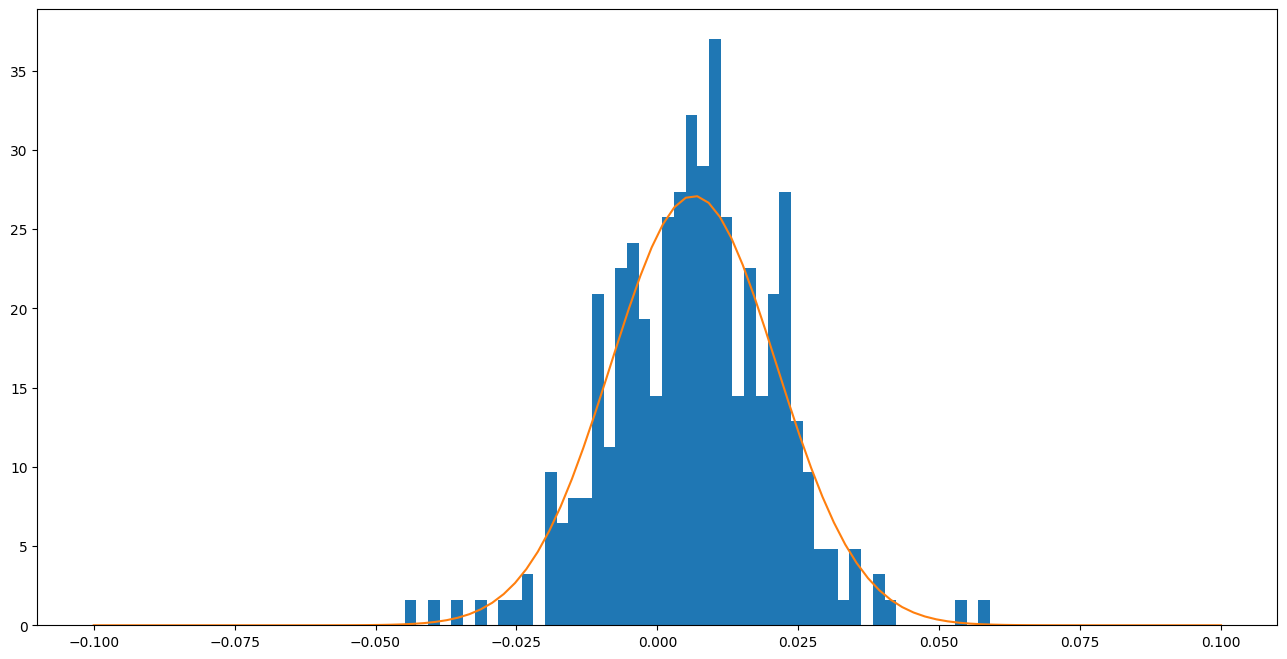

In [21]:
# Compute "CLosing"-"Opening"
forecast['Difference'] = forecast['True'] - forecast['Open']
mean_diff = forecast['Difference'].mean()
std_diff = forecast['Difference'].std()
forecast['Pred_difference'] = forecast['Forecast'] - forecast['Open']
print(f'Mean: {mean_diff}')
print(f'Std: {std_diff}')

# Plot a hist of the difference and the normal distribution
plt.figure(figsize=(16, 8))
plt.hist(forecast['Difference'], bins=50, density=True)
plt.plot(np.linspace(-0.1, 0.1, 100), 
         stats.norm.pdf(np.linspace(-0.1, 0.1, 100), mean_diff, std_diff))
plt.show()


In [22]:
def compute_prob(row, std):
    return stats.norm.cdf(row['Pred_difference'], 0, std)

forecast['Prob'] = forecast.apply(lambda row: compute_prob(row, std_diff), axis=1)
forecast.head()

,Forecast,True,Open,Difference,Pred_difference,Prob
Date,,,,,,
2022-07-25,0.633032,0.591927,0.593252,-0.001325,0.039780,0.996568
2022-07-26,0.625973,0.568714,0.579543,-0.010829,0.046430,0.999198
2022-07-27,0.626646,0.617657,0.581546,0.036111,0.045099,0.998911
2022-07-28,0.647544,0.629461,0.611203,0.018258,0.036342,0.993239
2022-07-29,0.664579,0.651690,0.630057,0.021632,0.034522,0.990513


We descale the data to have the real prices, as wz are now going to evaluate the performance of our investment strategy.

In [23]:
# Inverse the scaling
forecast['Forecast'] = y_scaler.inverse_transform(forecast['Forecast'].values.reshape(-1, 1))
forecast['True'] = y_scaler.inverse_transform(forecast['True'].values.reshape(-1, 1))
forecast['Open'] = open_scaler.inverse_transform(forecast['Open'].values.reshape(-1, 1))
forecast.head()

,Forecast,True,Open,Difference,Pred_difference,Prob
Date,,,,,,
2022-07-25,310.717734,300.269993,302.02,-0.001325,0.039780,0.996568
2022-07-26,308.923554,294.369998,298.53,-0.010829,0.046430,0.999198
2022-07-27,309.094503,306.810002,299.04,0.036111,0.045099,0.998911
2022-07-28,314.406371,309.809994,306.59,0.018258,0.036342,0.993239
2022-07-29,318.736144,315.460003,311.39,0.021632,0.034522,0.990513


## Strategy implementation and evaluation

We want to see, wtarting with $1000 how much we can earn using our investment strategy.

We will then compute the ROI (Return On Investment) using the following formula:
$$ROI = \frac{final\_value - initial\_value}{initial\_value}$$

Profit: 267.61324516044533
ROI: 26.76132451604453%


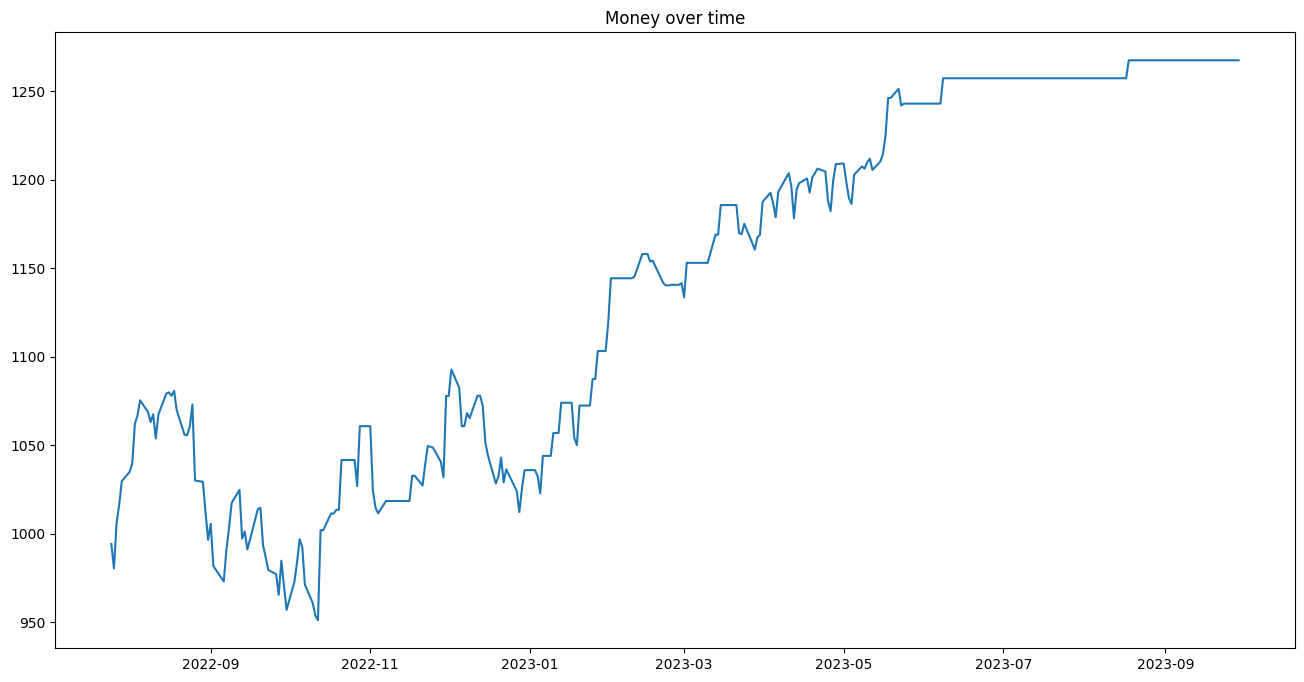

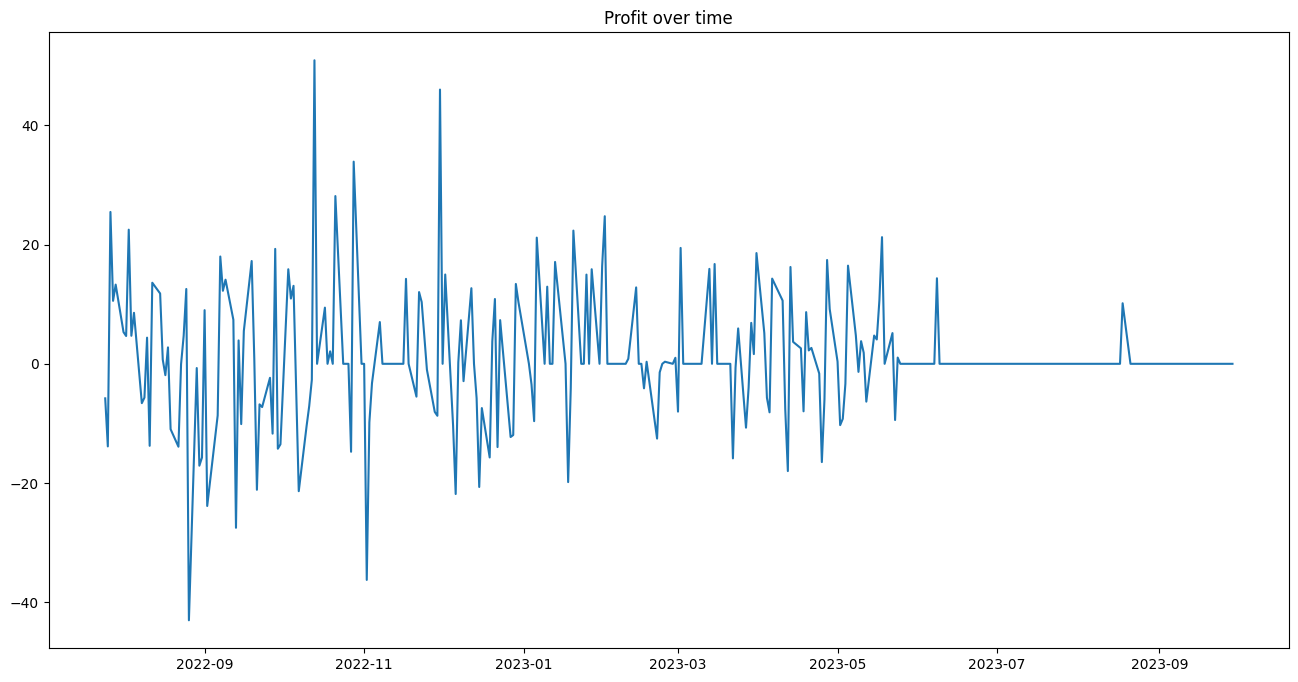

In [28]:
initial_money = 1000.0
# Initialize a "profit" column to store the profit made by the model
forecast['profit'] = 0.0
forecast['money'] = .0
money = initial_money

# Create a column with the date
forecast['date'] = forecast.index

# Drop the rows with missing values
forecast = forecast.dropna()

for date in forecast.index:
        
    open = forecast.loc[date]['Open']
    close = forecast.loc[date]['True']

    # If the model predicts that the price will go up, buy the stock
    profit = 0.0
    if forecast.loc[date]['Prob'] > 0.5:
        nb_shares = money / open
        profit = nb_shares * (close - open)
        
    money = money + profit
    forecast.loc[forecast['date'] == date, 'profit'] = profit
    forecast.loc[forecast['date'] == date, 'money'] = money

        
# print the final profit
print(f'Profit: {money - initial_money}')
# Print the ROI
print(f'ROI: {(money - initial_money) / initial_money * 100}%')

# Plot the daily amount of money
plt.figure(figsize=(16, 8))
plt.plot(forecast['date'], forecast['money'])
plt.title('Money over time')
plt.show()

# Plot the daily profit
plt.figure(figsize=(16, 8))
plt.plot(forecast['date'], forecast['profit'])
plt.title('Profit over time')
plt.show()
